## Generative Adversarial Networks 101

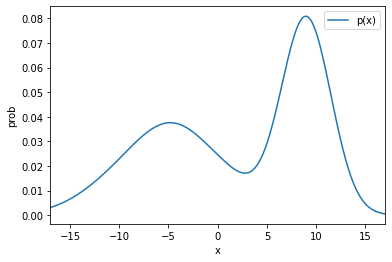

In [1]:
import numpy as np
import random
import torch, torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from optim.ellipsoid_sgd import EllipsoidSGD
DEBUG = 0
SHIFT = 0
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

def sample_real_data(size):
    x1 = torch.randn(size, 1) * 1.5 + 9 + SHIFT
    x2 = torch.randn(size, 1) * 5.0 - 5 + SHIFT

    u = torch.rand(size, 1)
    
    return np.where(u > 0.5, x1, x2)


def plot_data(x):
    kde = KernelDensity(bandwidth=2.0, kernel='gaussian')
    kde.fit(x)

    x_grid = np.linspace(-17 + SHIFT, 17 + SHIFT, 1000)[:, None]
    logprob = kde.score_samples(x_grid)

    plt.xlim([-17 + SHIFT, 17 + SHIFT])
    plt.plot(x_grid, np.exp(logprob))
    
    return kde

def plot_classifier(cls, kde_real, kde_fake):
    x_grid = np.linspace(-17 + SHIFT, 17 + SHIFT, 1000)[:, None]

    p_pred = torch.sigmoid(cls(torch.from_numpy(x_grid).float().cuda())).cpu()
    
    p_real = np.exp(kde_real.score_samples(x_grid))
    p_fake = np.exp(kde_fake.score_samples(x_grid))
    
    p_bayes = p_real / (p_real + p_fake + 1e-7)
    
    plt.xlim([-17 + SHIFT, 17 + SHIFT])
    plt.plot(x_grid, p_pred.detach().cpu(), 'r--')
    plt.plot(x_grid, p_bayes, 'r')

X_real = sample_real_data(10000)

plot_data(X_real)

plt.legend(['p(x)'])
plt.xlabel('x')
plt.ylabel('prob')

plt.show()

In [2]:
def get_H(model, diag=False, eps=0.1):
    # H0 = deepcopy(model)
    H_list = [];
    with torch.no_grad():
        if diag:
            for group in model.parameters():
                h_group = [];
                for p in group:
                    h_group.append(torch.diag(torch.norm(p.view(-1), dim=0) + eps))
                H_list.append(h_group)
                if DEBUG>0:
                    print("Parameter shape: ", p.size())
                    print("H ellipsoid matrix shape: ", h_group[-1].size())
        else:
            for group in model.parameters():
                h_group = []
                for p in group:
                    h_group.append(p.view(-1, 1).mm(p.view(1, -1)))
                H_list.append(h_group)
                if DEBUG>0:
                    print("Parameter shape: ", p.size())
                    print("H ellipsoid matrix shape: ", h_group[-1].size())
    if DEBUG>1:
        print(H_list)
    return H_list

In [3]:
# Generator is an MLP that converts noise into output data
# import copy
if DEVICE == "cpu":
    gen = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    ).cpu()
elif DEVICE=="cuda":
    gen = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    ).cuda()
gen_H = get_H(gen)

In [4]:
# Discriminator is mirroring the architecture of the generator
if DEVICE == "cpu":
    dis = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()).cpu()
elif DEVICE=="cuda":
    dis = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()).cuda()
dis_H = get_H(dis)

gen_opt = EllipsoidSGD(gen.parameters(), H=gen_H, lr=1e-3) # Try using Adam or SGD
dis_opt = EllipsoidSGD(dis.parameters(), H=dis_H, lr=1e-3) # TODO

# Binary Cross Entropy for discriminator, for generator we'll non-saturating loss
def calc_loss(real_preds=None, fake_preds=None, net_name=''):
    if net_name == 'dis':
        loss_real = -torch.log(real_preds)
        loss_fake = -torch.log(1 - fake_preds)

        loss = (loss_real + loss_fake) * 0.5
    
    elif net_name == 'gen':
        loss = -torch.log(fake_preds)

    return loss.mean()

In [5]:
# Alternative solution using PyTorch modules
# criterion = nn.BCEWithLogitsLoss()

# loss_D_real = criterion(real_scores, torch.ones_like(real_scores))
# loss_D_fake = criterion(fake_scores, torch.zeros_like(fake_scores))

# loss_G = criterion(fake_scores, torch.ones_like(fake_scores))

In [6]:
def train_dis(batch_size):
    # Forward real
    x_real = torch.from_numpy(sample_real_data(batch_size)).float().cuda()

    real_preds = dis(x_real)
    
    # Forward fake
    z = torch.randn(batch_size, 1).cuda()
    x_fake = gen(z)

    fake_preds = dis(x_fake.detach())

    # Discriminator losses
    loss_D = calc_loss(real_preds, fake_preds, net_name='dis')

    # Discriminator step
    dis_opt.zero_grad()
    loss_D.backward()
    dis_opt.step()

    return loss_D.item()

In [7]:
def train_gen(batch_size):
    # Forward fake
    z = torch.randn(batch_size, 1).cuda()
    x_fake = gen(z)

    fake_preds = dis(x_fake)

    # Generator losses
    loss_G = calc_loss(None, fake_preds, net_name='gen')

    # Generator step
    gen_opt.zero_grad()
    loss_G.backward()
    gen_opt.step()

    return loss_G.item()

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline



losses_D_hist = []
losses_G_hist = []

for i in range(1, 100000):    
    for _ in range(1):
        loss_D = train_dis(128)
    
    loss_G = train_gen(128)
    
    losses_D_hist.append(loss_D)
    losses_G_hist.append(loss_G)
    
    if i % 50 == 0:
        clear_output(True)
        print(f'Iter {i}')

        X_real = sample_real_data(10000)
        X_fake = gen(torch.randn(10000, 1).cuda()).detach().cpu().numpy()

        kde_real = plot_data(X_real)
        kde_fake = plot_data(X_fake)
        plt.legend(['p_real', 'q_fake'])
        plt.show()

        plot_classifier(dis, kde_real, kde_fake)
        plt.legend(['p_dis', 'p_bayes'])
        plt.show()

        plt.plot(losses_D_hist)
        plt.plot(losses_G_hist)
        plt.ylim([0, 2.5])
        plt.legend(['loss_D', 'loss_G'])
        plt.show()

RuntimeError: cuda runtime error (999) : unknown error at /opt/conda/conda-bld/pytorch_1587428398394/work/aten/src/THC/THCGeneral.cpp:47